In [129]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
import time 
from statsmodels.graphics.tsaplots import acf
from scipy.signal import periodogram
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
from scipy.interpolate import interp1d
from collections import OrderedDict

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_row', 1000)

# Import data

## Test data 

In [130]:
path = "/Users/calumthompson/Documents/Final year project/Data/S&P500 1mins/*"   #put folder data is in here

data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname, dtype = {'<TIME>': str})
    
    data_merge.append(x)

SandP_1mins = pd.concat(data_merge)

SandP_1mins.columns = SandP_1mins.columns.str.replace("<","").str.replace(">","")

SandP_1mins['TIMESTAMP'] = SandP_1mins['DATE'].astype(str) + SandP_1mins['TIME'].astype(str)
SandP_1mins['TIMESTAMP'] = pd.to_datetime(SandP_1mins['TIMESTAMP'] ,format='%Y%m%d%H%M%S')
SandP_1mins['DATE'] = pd.to_datetime(SandP_1mins['DATE'] ,format='%Y%m%d')

SandP_1mins = SandP_1mins[['DATE','TIMESTAMP','TIME','OPEN','HIGH','LOW','CLOSE','VOL']]
SandP_1mins = SandP_1mins.sort_values('TIMESTAMP')

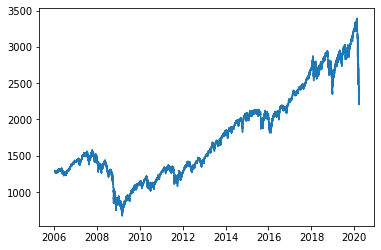

In [131]:
plt.plot(SandP_1mins['DATE'], SandP_1mins['CLOSE'])
plt.show();

### Fractional change to close value

In [132]:
close_prices = pd.DataFrame(SandP_1mins.groupby('DATE')['CLOSE'].last()).reset_index()
close_prices['Change %'] = (close_prices['CLOSE'].diff()/ close_prices['CLOSE']) *100

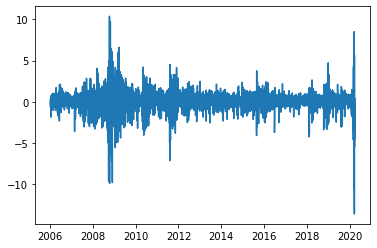

In [133]:
plt.plot(close_prices['DATE'], close_prices['Change %'])

# Import lyapunov data

In [134]:
path = "/Users/calumthompson/Documents/Final year project/Implementation/lyapunov_output/CSVs/*"   #put folder data is in here

data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname, parse_dates = ['DATE'])
    
    data_merge.append(x)

FLE_output = pd.concat(data_merge)

FLE_output.sort_values(by = 'DATE', inplace = True)


In [135]:
FLE_df = pd.merge(FLE_output,close_prices)
FLE_df = FLE_df.loc[FLE_df['lyapunov_exponent'] >= 0 ]

In [155]:
FLE_df['FLE change %'] = (FLE_df['lyapunov_exponent'].diff()/ FLE_df['lyapunov_exponent']) *100

# FLE_df['FLE change %'] =  np.where(np.abs(FLE_df['FLE change %']) < 10000 ,FLE_df['FLE change %'], np.nan )

In [137]:
FLE_df['lyapunov_exponent'].describe()

count    3529.000000
mean        0.624102
std         0.395404
min         0.000179
25%         0.301160
50%         0.605456
75%         0.916600
max         1.768275
Name: lyapunov_exponent, dtype: float64

In [146]:
FLE_df.head(5)

,DATE,lyapunov_exponent,error,CLOSE,Change %,FLE change %
0,2006-01-10,0.874142,1.665335e-16,1289.69,NaN,NaN
1,2006-01-11,0.690631,5.551115e-17,1294.18,0.346938,-26.571519
2,2006-01-12,0.619161,2.775558e-17,1286.06,-0.631386,-11.542958
3,2006-01-13,0.869448,8.881784e-17,1287.61,0.120378,28.786815
4,2006-01-17,1.133656,1.665335e-16,1282.93,-0.364790,23.305894


# Abs value vs abs FLE

(733042.0, 733772.0)

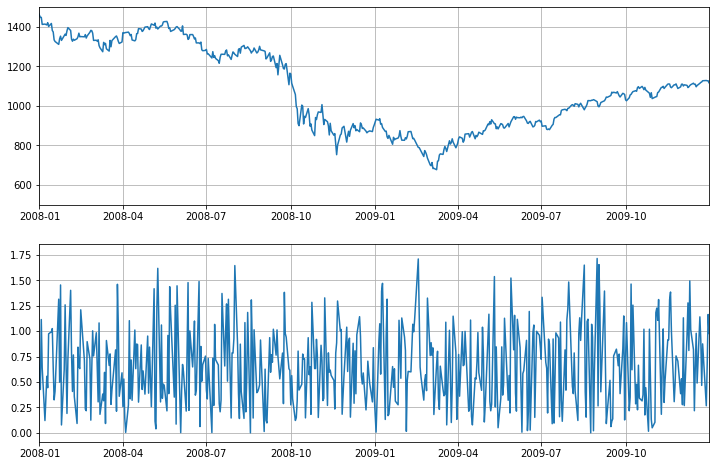

In [149]:

plot_start = pd.to_datetime('2008-01-01')
plot_end = pd.to_datetime('2009-12-31')

fig, axs = plt.subplots(2,figsize = [12,8])

axs[0].plot( FLE_df['DATE'],FLE_df['CLOSE'], label = 'fractional change')
axs[0].grid()
axs[0].set_xlim(left = plot_start, right = plot_end)
axs[0].set_ylim(500,1500)

###################

axs[1].plot(FLE_df['DATE'], FLE_df['lyapunov_exponent'])
axs[1].grid()
axs[1].set_xlim(left = plot_start, right = plot_end)


# Abs value vs fractional lyapunov


(-100, 100)

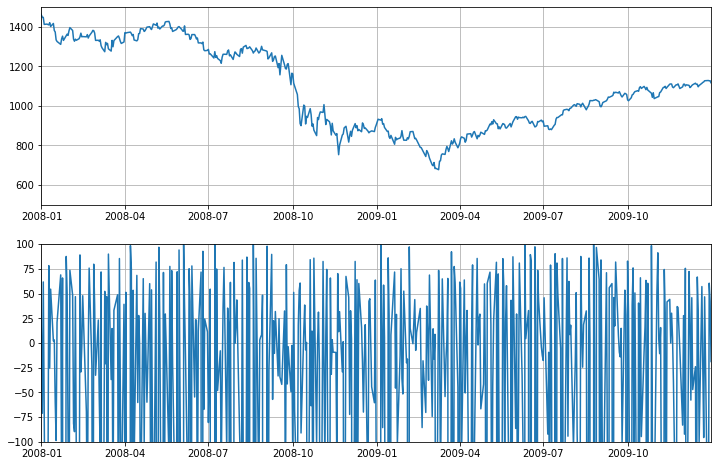

In [157]:
plot_start = pd.to_datetime('2008-01-01')
plot_end = pd.to_datetime('2009-12-31')

fig, axs = plt.subplots(2,figsize = [12,8])

axs[0].plot( FLE_df['DATE'],FLE_df['CLOSE'], label = 'fractional change')
axs[0].grid()
axs[0].set_xlim(left = plot_start, right = plot_end)
axs[0].set_ylim(500,1500)

###################

axs[1].plot(FLE_df['DATE'], FLE_df['FLE change %'])
axs[1].grid()
axs[1].set_xlim(left = plot_start, right = plot_end)
axs[1].set_ylim(-100,100)

(-100, 100)

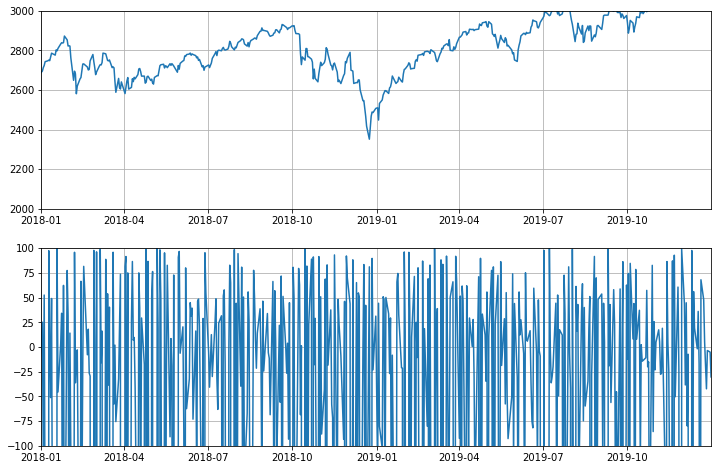

In [160]:
plot_start = pd.to_datetime('2018-01-01')
plot_end = pd.to_datetime('2019-12-31')

fig, axs = plt.subplots(2,figsize = [12,8])

axs[0].plot( FLE_df['DATE'],FLE_df['CLOSE'], label = 'fractional change')
axs[0].grid()
axs[0].set_xlim(left = plot_start, right = plot_end)
axs[0].set_ylim(2000,3000)

###################

axs[1].plot(FLE_df['DATE'], FLE_df['FLE change %'])
axs[1].grid()
axs[1].set_xlim(left = plot_start, right = plot_end)
axs[1].set_ylim(-100,100)

# Plot returns with days where FLE < quantile
Percentile calculated over the preceding 100 FLEs 

In [102]:
def plot_FLE_below_threshold(FLE_df, quantile_value,quantile_window, event_window, plot_start = None ,plot_end = None, show_red_lines = False ):

    plot_start = pd.to_datetime(plot_start)
    plot_end = pd.to_datetime(plot_end)
    
    FLE_df['threshold'] =  FLE_df['lyapunov_exponent'].rolling(quantile_window).quantile(quantile_value)
    FLE_df['Below_threshold'] = np.where(FLE_df['lyapunov_exponent'] < FLE_df['threshold'], 1,0)
    FLE_df['running_below_threshold'] = FLE_df['Below_threshold'].rolling(event_window).sum().fillna(0)

    fig, axs = plt.subplots(2,figsize = [18,12])
    fig.suptitle('Returns and FLE results for ' + str(plot_start.strftime('%d-%m-%Y')) + " to " + str(plot_end.strftime('%d-%m-%Y')), size = 14)    

    axs[0].plot( FLE_df['DATE'],FLE_df['Change %'], label = 'fractional change')
    axs[0].grid()
    
    if show_red_lines:
        axs[0].set_title('Fractional price changes with FLEs below threshold')
    else:
        axs[0].set_title('Fractional price changes')
    
    axs[0].set_xlim(left = plot_start, right = plot_end)

    if show_red_lines:
        for i in range(0,FLE_df.shape[0]):
            if FLE_df.iloc[i]['Below_threshold']:
                axs[0].axvline(FLE_df.iloc[i]['DATE'], linestyle = ':', c = 'r', label = 'FLE in ' + str(quantile_value) + ' quantile')

    handles, labels = axs[0].get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))

    axs[0].legend(by_label.values(), by_label.keys())
            
    ###################
    
    axs[1].plot(FLE_df['DATE'], FLE_df['running_below_threshold'])
    axs[1].grid()
    axs[1].set_title('Number of breaches in preceding ' + str(event_window) + ' days')
    axs[1].set_xlim(left = plot_start, right = plot_end)

    plt.show();
    
    #return FLE_df

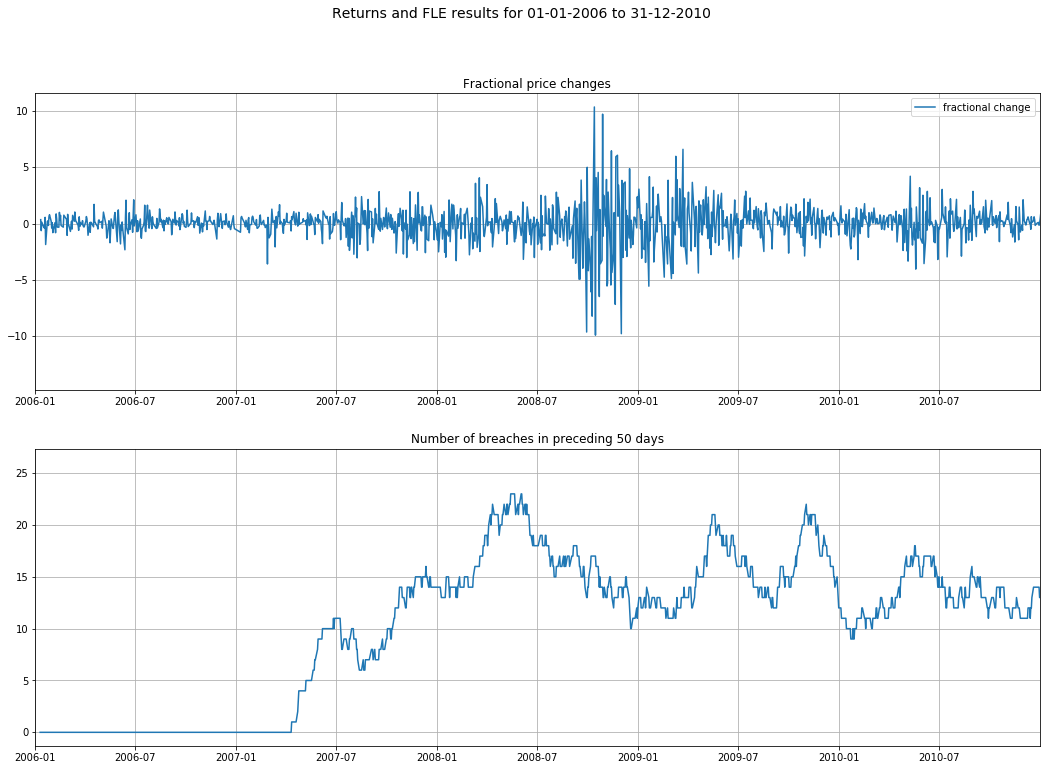

In [165]:
plot_FLE_below_threshold(FLE_df, 
                         quantile_value = 0.3,
                         quantile_window = 300, 
                         event_window = 50, 
                         show_red_lines = False,
                         plot_start = '2006-01-01', 
                         plot_end = '2010-12-31')

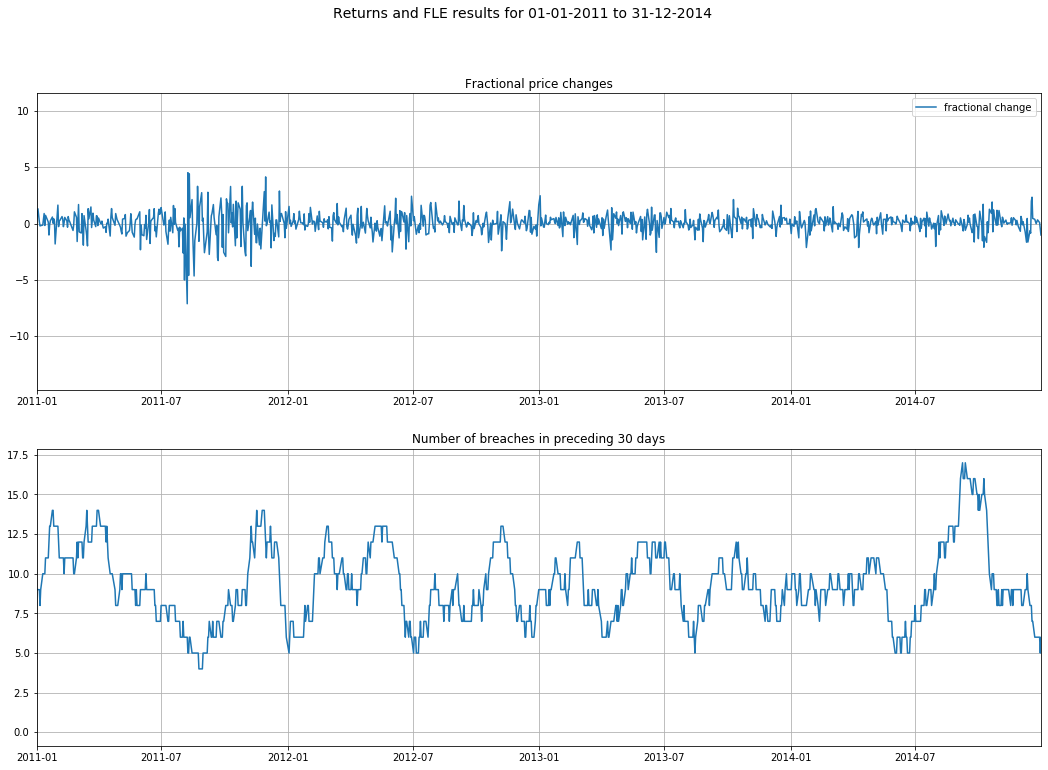

In [162]:
plot_FLE_below_threshold(FLE_df, 
                         quantile_value = 0.3,
                         quantile_window = 100, 
                         event_window = 30, 
                         show_red_lines = False,
                         plot_start = '2011-01-01', 
                         plot_end = '2014-12-31')

# Identify FLE -> 0 

- Values in lowest percentile of FLE?

- Histogram of FLE values

- Get PNGs of all plots

In [ ]:
plot_data['lyapunov_exponent'].hist()

# Identify low FLE values

In [9]:
percentile_1 = np.percentile(FLE_2008['FLE_df'], 1)
percentile_5 = np.percentile(FLE_2008['FLE_df'], 5)
percentile_10 = np.percentile(FLE_2008['FLE_df'], 10)
percentile_15 = np.percentile(FLE_2008['FLE_df'], 15)
percentile_20 = np.percentile(FLE_2008['FLE_df'], 20)

In [19]:
a = pd.DataFrame([1,2,3,4,5,6,7,8])

In [25]:
a['Rolling quantile'] = a[0].rolling(3).quantile(0.5)
a

,0,Rolling quantile
0,1,NaN
1,2,NaN
2,3,2.0
3,4,3.0
4,5,4.0
5,6,5.0
6,7,6.0
7,8,7.0


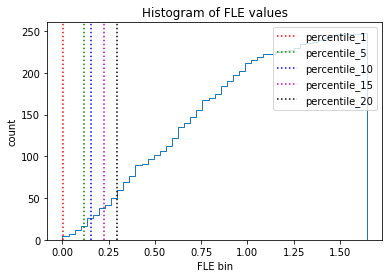

In [10]:
histogram = plt.hist(FLE_2008['lyapunov_exponent'], bins = 50, cumulative= True, histtype = 'step' )
plt.title('Histogram of FLE values')
plt.xlabel('FLE bin')
plt.ylabel('count')

plt.axvline(percentile_1, c='r', linestyle = ':', label = 'percentile_1')
plt.axvline(percentile_5, c='g', linestyle = ':', label = 'percentile_5')
plt.axvline(percentile_10, c='b', linestyle = ':', label = 'percentile_10')
plt.axvline(percentile_15, c='m', linestyle = ':', label = 'percentile_15')
plt.axvline(percentile_20, c='k', linestyle = ':', label = 'percentile_20')

plt.legend(loc = 'best')
plt.show();